In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP import confusion_table
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, auc, roc_curve,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree

## Decision tree

In [3]:
Khan = load_data('Khan') #load the Khan dataset
Khan['xtrain'].shape, Khan['xtest'].shape #number of instances and features in training and test data

((63, 2308), (20, 2308))

In [4]:
Xtrain = Khan['xtrain']
ytrain = Khan['ytrain']
Xtest = Khan['xtest']
ytest = Khan['ytest']

In [43]:
# set tuning values
tuned_parameters = [{"ccp_alpha": [1,0.1,0.01,0.001,0.0001]}]
treeCV = GridSearchCV(DecisionTreeClassifier(random_state=67), tuned_parameters, scoring='accuracy',cv=10)
# more details see https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
treeCV.fit(Xtrain, ytrain)
print("Best parameters set found on validation set:")
print()
print(treeCV.best_params_)
print()
print("Grid scores on validation set:")
print()
means = treeCV.cv_results_["mean_test_score"]
stds = treeCV.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, treeCV.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


Best parameters set found on validation set:

{'ccp_alpha': 0.1}

Grid scores on validation set:

0.362 (+/-0.044) for {'ccp_alpha': 1}
0.860 (+/-0.169) for {'ccp_alpha': 0.1}
0.829 (+/-0.167) for {'ccp_alpha': 0.01}
0.829 (+/-0.167) for {'ccp_alpha': 0.001}
0.829 (+/-0.167) for {'ccp_alpha': 0.0001}


Play with different random states to check the change in decision trees with different training data.

In [57]:
# predict test set labels
ypred_tree = treeCV.predict(Xtest)
accuracy_score(ytest,ypred_tree)

0.8

In [58]:
confusion_table(ypred_tree, ytest)

Truth,1,2,3,4
Predicted,,,,
1,3,0,0,0
2,0,5,0,1
3,0,0,5,1
4,0,1,1,3


In [59]:
yscores_tree = treeCV.predict_proba(Xtest) #obtain AUC value
roc_auc_score(ytest,yscores_tree,multi_class="ovr",average="micro")

0.8541666666666667

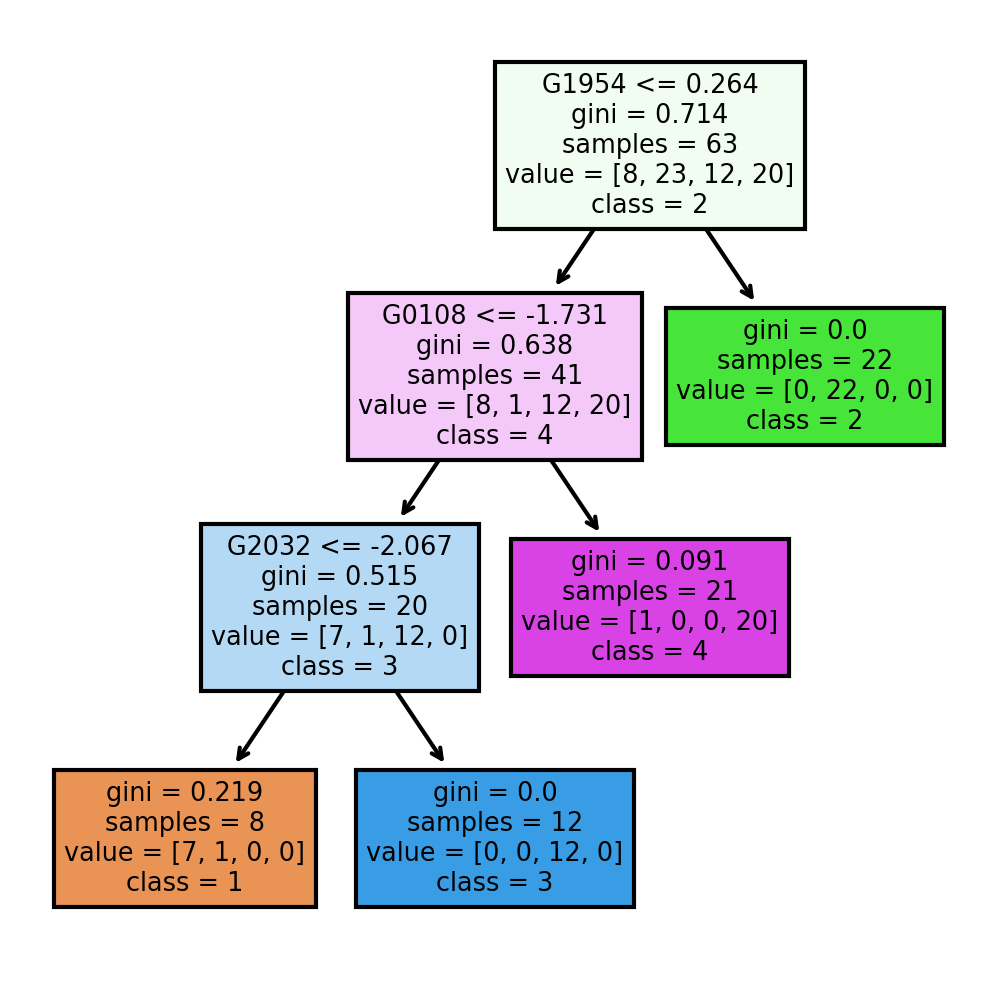

In [45]:
# visualise tree
dt = DecisionTreeClassifier(ccp_alpha=0.1,random_state=67)
dt_vis=dt.fit(Xtrain,ytrain)
fn=Xtrain.columns
cn=['1','2','3','4']
fig, axes = subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dt_vis,
               feature_names = fn, 
               class_names=cn,
               filled = True)
fig


## Random forest

In [5]:
# set tuning values
tuned_parameters = [{"max_features": [5,10,20,30,40,50,"sqrt"]}]
rfCV = GridSearchCV(RandomForestClassifier(n_estimators=500,bootstrap=True,oob_score=True,random_state=0), tuned_parameters, scoring='accuracy',cv=10)
# more details see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rfCV.fit(Xtrain, ytrain)
print("Best parameters set found on validation set:")
print()
print(rfCV.best_params_)
print()
print("Grid scores on validation set:")
print()
means = rfCV.cv_results_["mean_test_score"]
stds = rfCV.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, rfCV.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


Best parameters set found on validation set:

{'max_features': 10}

Grid scores on validation set:

0.986 (+/-0.043) for {'max_features': 5}
1.000 (+/-0.000) for {'max_features': 10}
1.000 (+/-0.000) for {'max_features': 20}
1.000 (+/-0.000) for {'max_features': 30}
1.000 (+/-0.000) for {'max_features': 40}
1.000 (+/-0.000) for {'max_features': 50}
1.000 (+/-0.000) for {'max_features': 'sqrt'}


In [6]:
# predict test set labels
ypred_rf = rfCV.predict(Xtest)
accuracy_score(ytest,ypred_rf)

0.8

In [7]:
confusion_table(ypred_rf, ytest)

Truth,1,2,3,4
Predicted,,,,
1,3,0,0,0
2,0,6,1,0
3,0,0,2,0
4,0,0,3,5


In [8]:
yscores_rf = rfCV.predict_proba(Xtest) #obtain AUC value
roc_auc_score(ytest,yscores_rf,multi_class="ovr",average="micro")

0.9299999999999999

In [26]:
# get variable importance, e.g. mean decrease in gini index
rf = RandomForestClassifier(n_estimators=500,max_features=10,bootstrap=True,oob_score=True,random_state=0).fit(Xtrain,ytrain)
rf_importances = rf.feature_importances_

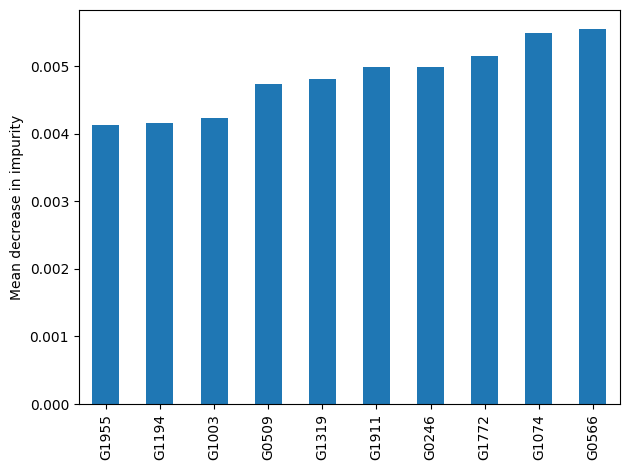

In [27]:
#plot the most important features
index = np.argsort(rf_importances)
forest_importances = pd.Series(rf_importances[index[-10:]], index=rf.feature_names_in_[index[-10:]])

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## AdaBoost

In [70]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, random_state=0)
# more details see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
# set tuning values
tuned_parameters = [{"learning_rate": [0.001,0.01,0.1,1]}]
adaCV = GridSearchCV(ada, tuned_parameters, scoring='accuracy',cv=10)
adaCV.fit(Xtrain, ytrain)
print("Best parameters set found on validation set:")
print()
print(adaCV.best_params_)
print()
print("Grid scores on validation set:")
print()
means = adaCV.cv_results_["mean_test_score"]
stds = adaCV.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, adaCV.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


Best parameters set found on validation set:

{'learning_rate': 0.1}

Grid scores on validation set:

0.860 (+/-0.160) for {'learning_rate': 0.001}
0.862 (+/-0.142) for {'learning_rate': 0.01}
0.890 (+/-0.152) for {'learning_rate': 0.1}
0.860 (+/-0.142) for {'learning_rate': 1}


In [71]:
# predict test set labels
ypred_ada = adaCV.predict(Xtest)
accuracy_score(ytest,ypred_ada)

0.9

In [72]:
confusion_table(ypred_ada, ytest)

Truth,1,2,3,4
Predicted,,,,
1,3,0,0,0
2,0,5,0,0
3,0,0,5,0
4,0,1,1,5


In [73]:
yscores_ada = adaCV.predict_proba(Xtest) #obtain AUC value
roc_auc_score(ytest,yscores_ada,multi_class="ovr",average="micro")

0.9966666666666668

## Gradient boosting

In [78]:
grd = GradientBoostingClassifier(max_depth=3, n_estimators=100, random_state=0)
# more details see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
# set tuning values
tuned_parameters = [{"learning_rate": [0.001,0.01,0.1,1]}]
grdCV = GridSearchCV(grd, tuned_parameters, scoring='accuracy',cv=10)
grdCV.fit(Xtrain, ytrain)
print("Best parameters set found on validation set:")
print()
print(grdCV.best_params_)
print()
print("Grid scores on validation set:")
print()
means = grdCV.cv_results_["mean_test_score"]
stds = grdCV.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, grdCV.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


Best parameters set found on validation set:

{'learning_rate': 0.01}

Grid scores on validation set:

0.614 (+/-0.095) for {'learning_rate': 0.001}
0.902 (+/-0.109) for {'learning_rate': 0.01}
0.855 (+/-0.133) for {'learning_rate': 0.1}
0.810 (+/-0.155) for {'learning_rate': 1}


In [79]:
# predict test set labels
ypred_grd = grdCV.predict(Xtest)
accuracy_score(ytest,ypred_grd)

0.9

In [80]:
confusion_table(ypred_grd, ytest)

Truth,1,2,3,4
Predicted,,,,
1,3,0,0,0
2,0,5,0,1
3,0,0,6,0
4,0,1,0,4


In [81]:
yscores_grd = grdCV.predict_proba(Xtest) #obtain AUC value
roc_auc_score(ytest,yscores_grd,multi_class="ovr",average="micro")

0.9941666666666666

In [28]:
# get variable importance, e.g. mean decrease in gini index
grd = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=100, random_state=0).fit(Xtrain,ytrain)
grd_importances = grd.feature_importances_

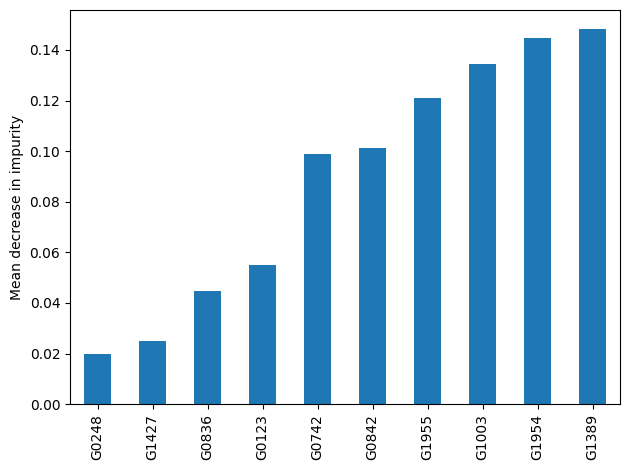

In [30]:
#plot the most important features
grd_index = np.argsort(grd_importances)
boosting_importances = pd.Series(grd_importances[grd_index[-10:]], index=grd.feature_names_in_[grd_index[-10:]])

fig, ax = plt.subplots()
boosting_importances.plot.bar()
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()